In [104]:
import praw
from datetime import datetime
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import empath
import string
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from wordcloud import WordCloud
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from pprint import pprint





import warnings
warnings.filterwarnings('ignore')

# DATA COLLECTION

In [69]:
# Initialize Reddit API client using PRAW
reddit = praw.Reddit(client_id='K7By9bAhMWAtD658AfOe4A',
                     client_secret='5QHABnqKzI5eaI9RozEZgXE7VqmEOw',
                     user_agent='MyBot/0.0.1',
                     username='Frequent-Morning-897',
                     password='smmspring23')
 


# List of post IDs
post_ids = ['129cl6o','127uy6k','126lncd','pr3ypv','126zh31','129clhx','125wj0d','125wol4','125wol4','121g5do',
            '125ea4j','125khbv','1266xap','12gr6bf']

data = []

# Loop through each post ID and retrieve comments
for post_id in post_ids:
    print(f"Getting post_id: {post_id}")
    post = reddit.submission(id=post_id)
    comments = post.comments
    count = 0
    for comment in comments:
        #author = comment.author.name if comment.author else '[deleted]'
        try:
            text = comment.body
            timestamp = comment.created_utc
            date = datetime.utcfromtimestamp(timestamp)
            data.append([post_id, post.title, date, text])
            count = count + 1
            # Retrieve sub-comments for current comment
            sub_comments = comment.replies
            sub_comments.replace_more(limit=None)  # Retrieve all sub-comments

            # Loop through each sub-comment and append to data list
            for sub_comment in sub_comments:
                #author = sub_comment.author.name if sub_comment.author else '[deleted]'
                text = sub_comment.body
                timestamp = sub_comment.created_utc
                date = datetime.utcfromtimestamp(timestamp)
                data.append([post_id, post.title, date, text])
                count = count + 1
        except Exception as e:
            print(f"Exception: {e}")
        
    print(f"Fetched {count} comments from post: {post_id}")
        
# Create dataframe from data list
df = pd.DataFrame(data, columns=['post_id','title','date', 'text' ])

Getting post_id: 129cl6o
Fetched 75 comments from post: 129cl6o
Getting post_id: 127uy6k
Fetched 2 comments from post: 127uy6k
Getting post_id: 126lncd
Fetched 40 comments from post: 126lncd
Getting post_id: pr3ypv
Fetched 20 comments from post: pr3ypv
Getting post_id: 126zh31
Fetched 26 comments from post: 126zh31
Getting post_id: 129clhx
Fetched 7 comments from post: 129clhx
Getting post_id: 125wj0d
Fetched 111 comments from post: 125wj0d
Getting post_id: 125wol4
Fetched 61 comments from post: 125wol4
Getting post_id: 125wol4
Fetched 61 comments from post: 125wol4
Getting post_id: 121g5do
Fetched 37 comments from post: 121g5do
Getting post_id: 125ea4j
Fetched 52 comments from post: 125ea4j
Getting post_id: 125khbv
Exception: 'MoreComments' object has no attribute 'body'
Fetched 464 comments from post: 125khbv
Getting post_id: 1266xap
Fetched 40 comments from post: 1266xap
Getting post_id: 12gr6bf
Fetched 79 comments from post: 12gr6bf


In [311]:
df.shape

(1075, 5)

# DATA PREPROCESSING

In [312]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    
    if not text:
        return ""
    
    text = text.lower()
    words = nltk.word_tokenize(text)
    # remove stop words from the text
    filtered_words = [word for word in words if word not in stop_words]
    filtered_words = [word for word in words if word not in ["s", "nt"]]
#     filtered_words = [word for word in words if word not in ["s"]]
    # join the filtered words back into a text
    filtered_text = " ".join(filtered_words)
    clean_text = re.sub('[^A-Za-z0-9 ]+', '', filtered_text)
    
    return clean_text

In [315]:
df["clean_text"] = df["text"].apply(preprocess)

# SENTIMENT ANALYSIS: EMPATH MODEL

In [316]:
df = df.loc[:,['date','clean_text']]

lexicon = empath.Empath()

def clean_junk(text):
    out = []
    for word in text.split():
        if (len(word) == 1 and word.endswith("u")) or (len(word) == 1 and word.endswith("s")) or (len(word) == 2 and word.endswith("nt")) or (len(word) == 2 and word.endswith("re")):
            pass
        else:
            out.append(word)
    return " ".join(out)

def preprocess_data(df):
    df["new_text"] = df["clean_text"].apply(lambda x:x.translate(str.maketrans('','',string.punctuation)) if isinstance(x, str) else "")
    df["new_text"] = df["clean_text"].apply(clean_junk)

    df["date"] = pd.to_datetime(df["date"])
    df["month"] = df['date'].dt.month 
    return df

def sentiment(df):
    positive_emotion = []
    negative_emotion = []
    for text in df['new_text']:
        
        text = str(text).split()
        text = filter(None, [clean_junk(word) for word in text])
        text = " ".join(text)
        scores = lexicon.analyze(text)
        positive_emotion.append(scores['positive_emotion'])
        negative_emotion.append(scores['negative_emotion'])
    
    out = []
    for x,y in zip(positive_emotion, negative_emotion):
        if x == 0.0 and y == 0.0:
            out.append("Neutral")
        elif x > y:
            out.append("Positive")
        else:
            out.append("Negative")
        
    df['sentiment_score'] = out
    
def tag_sentiment(x):
    if x["positive_emotion"] > 0:
        return "POS"
    
    if x["negative_emotion"] > 0:
        return "NEG"

    return "NEU"

In [317]:
df = preprocess_data(df)

In [318]:
sentiment(df)

In [319]:
df

,date,clean_text,new_text,month,sentiment_score
0,2023-04-02 08:03:02,the groupsindividuals who would use this techn...,the groupsindividuals who would use this techn...,4,Neutral
1,2023-04-02 10:57:20,as a researcher i will continue to do my exper...,as a researcher i will continue to do my exper...,4,Neutral
2,2023-04-02 10:21:35,yep,yep,4,Neutral
3,2023-04-03 06:45:42,and i m sure a few of them are the ones callin...,and i m sure a few of them are the ones callin...,4,Neutral
4,2023-04-02 07:48:50,1000 transportation industry leaders called fo...,1000 transportation industry leaders called fo...,4,Neutral
...,...,...,...,...,...
1070,2023-04-11 09:52:26,giga,giga,4,Neutral
1071,2023-04-11 22:43:57,easy to argue in favor of it from a theoretica...,easy to argue in favor of it from a theoretica...,4,Neutral
1072,2023-04-12 16:47:25,i am not arguing for people to be displaced b...,i am not arguing for people to be displaced bu...,4,Neutral
1073,2023-04-11 23:57:12,slowing down ai development is important for a...,slowing down ai development is important for a...,4,Negative


In [320]:
df["sentiment_score"].value_counts()

sentiment_score
Neutral     621
Negative    361
Positive     93
Name: count, dtype: int64

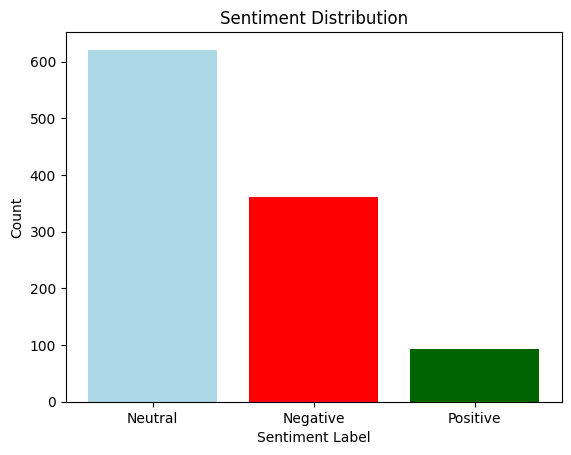

In [321]:
# Count the number of instances of each sentiment label
sentiment_counts = df['sentiment_score'].value_counts()

colors = ['lightblue', 'red', 'darkgreen']

# Create bar graph
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

# TOPIC MODELING

In [322]:
pos_df = df[df["sentiment_score"] == "Positive"]
neg_df = df[df["sentiment_score"] == "Negative"]

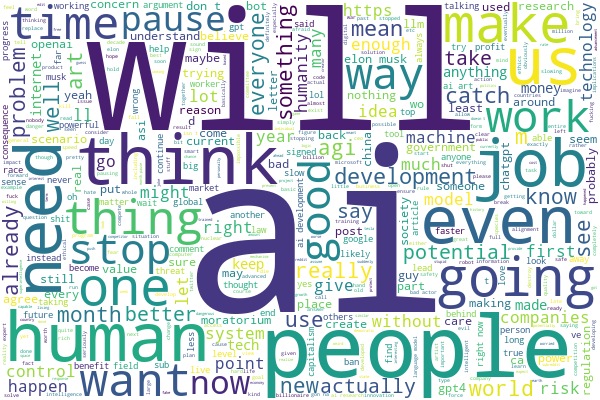

In [323]:
data = ','.join(list(df['new_text'].values))

wordcloud = WordCloud(background_color="white", max_words=1000, contour_color='steelblue', width=600, height=400)
wordcloud.generate(data)
wordcloud.to_image()

In [324]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','s','nt'])

def words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def rmstopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.new_text.values.tolist()
all_data_words = list(words(data))
all_data_words = rmstopwords(all_data_words)

In [325]:
id2word = corpora.Dictionary(all_data_words)
texts = all_data_words
corpus = [id2word.doc2bow(text) for text in texts]

In [326]:
num_topics = 5
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pprint(lda_model.print_topics())

doc_lda = lda_model[corpus]

[(0,
  '0.034*"ai" + 0.009*"would" + 0.008*"like" + 0.007*"people" + 0.005*"want" + '
  '0.005*"development" + 0.005*"art" + 0.004*"need" + 0.004*"think" + '
  '0.004*"going"'),
 (1,
  '0.022*"ai" + 0.012*"people" + 0.008*"like" + 0.007*"even" + 0.006*"human" + '
  '0.006*"one" + 0.005*"would" + 0.005*"development" + 0.004*"jobs" + '
  '0.004*"get"'),
 (2,
  '0.021*"ai" + 0.008*"people" + 0.007*"think" + 0.005*"like" + 0.005*"could" '
  '+ 0.005*"open" + 0.005*"going" + 0.005*"catch" + 0.005*"us" + 0.005*"work"'),
 (3,
  '0.026*"ai" + 0.008*"us" + 0.007*"people" + 0.006*"like" + 0.005*"think" + '
  '0.005*"could" + 0.005*"would" + 0.005*"agi" + 0.004*"humans" + '
  '0.004*"stop"'),
 (4,
  '0.019*"ai" + 0.010*"people" + 0.007*"going" + 0.007*"think" + 0.006*"even" '
  '+ 0.006*"would" + 0.006*"us" + 0.004*"like" + 0.004*"need" + '
  '0.004*"something"')]


In [327]:
# create an empty DataFrame
topics_df_1 = pd.DataFrame()

# loop through each topic and extract the top 10 words
for idx, topic in lda_model.print_topics(-1):
    words = topic.split("+")
    words_list = [word.split("*")[1].replace('"', '').strip() for word in words]
    
    # add the topic and top 10 words to the DataFrame
    topics_df_1[f"Topic {idx+1}"] = words_list[:10]

# display the DataFrame
print(topics_df_1.to_string(index=False))

    Topic 1     Topic 2 Topic 3 Topic 4   Topic 5
         ai          ai      ai      ai        ai
      would      people  people      us    people
       like        like   think  people     going
     people        even    like    like     think
       want       human   could   think      even
development         one    open   could     would
        art       would   going   would        us
       need development   catch     agi      like
      think        jobs      us  humans      need
      going         get    work    stop something


In [355]:
topics_df_1.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,ai,ai,ai,ai,ai
1,would,people,people,us,people
2,like,like,think,people,going
3,people,even,like,like,think
4,want,human,could,think,even
5,development,one,open,could,would
6,art,would,going,would,us
7,need,development,catch,agi,like
8,think,jobs,us,humans,need
9,going,get,work,stop,something


In [328]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./smm_results/ldavis_prepared_'+str(num_topics))
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './smm_results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.042602  0.016532       1        1  24.791597
1     -0.014341 -0.007854       2        1  23.583426
3      0.009975  0.029537       3        1  20.333697
4      0.003716 -0.049320       4        1  17.134353
2      0.043252  0.011105       5        1  14.156927, topic_info=      Term        Freq       Total Category  logprob  loglift
821    bot   21.000000   21.000000  Default  30.0000  30.0000
126   open   43.000000   43.000000  Default  29.0000  29.0000
198  think  116.000000  116.000000  Default  28.0000  28.0000
3    going  104.000000  104.000000  Default  27.0000  27.0000
48      us  120.000000  120.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
572  human   10.221241   84.159398   Topic5  -5.8330  -0.1533
118   make    9.563171   81.860553   Topic5  -5.8996  -0.1921
145  world    8.609091   53.747394   Topic5  -6.0047   0.1235
8    would   10.452243  144.167047   Topic5  -5.8107  -0.6692
82     get    8.989985   80.496631   Topic5  -5.9614  -0.2371

[406 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
50        1  0.329782  actually
50        2  0.175884  actually
50        3  0.219855  actually
50        4  0.197869  actually
50        5  0.065956  actually
...     ...       ...       ...
1082      2  0.186271       yes
1082      3  0.419109       yes
1082      4  0.093135       yes
1082      5  0.046568       yes
2212      5  0.473279       zip

[813 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 5, 3])

# POSITIVE DATA TOPIC MODELING

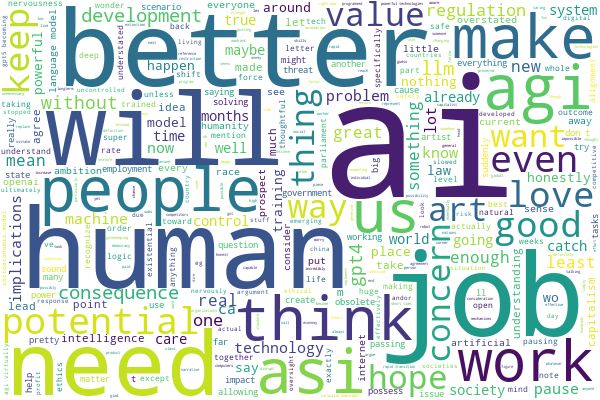

In [364]:
pos_data = ','.join(list(pos_df['new_text'].values))

wordcloud = WordCloud(background_color="white", max_words=1000, contour_color='steelblue', width=600, height=400)

wordcloud.generate(pos_data)

wordcloud.to_image()

In [365]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','s','nt'])

def words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def rmstopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

pos_data = pos_df.new_text.values.tolist()
pos_data_words = list(words(pos_data))
pos_data_words = rmstopwords(pos_data_words)

In [366]:
id2word = corpora.Dictionary(pos_data_words)
pos_texts = pos_data_words
corpus = [id2word.doc2bow(text) for text in pos_texts]
num_topics = 5
lda_model_pos = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pprint(lda_model_pos.print_topics())

doc_lda = lda_model_pos[corpus]

[(0,
  '0.017*"ai" + 0.008*"asi" + 0.008*"could" + 0.008*"better" + 0.007*"would" + '
  '0.006*"agi" + 0.006*"hope" + 0.005*"love" + 0.005*"us" + 0.005*"something"'),
 (1,
  '0.033*"ai" + 0.015*"would" + 0.010*"better" + 0.007*"jobs" + 0.007*"could" '
  '+ 0.007*"people" + 0.006*"work" + 0.006*"think" + 0.006*"make" + '
  '0.006*"art"'),
 (2,
  '0.024*"ai" + 0.008*"better" + 0.008*"could" + 0.006*"control" + '
  '0.006*"think" + 0.006*"would" + 0.005*"good" + 0.005*"hope" + '
  '0.005*"humans" + 0.005*"like"'),
 (3,
  '0.015*"ai" + 0.009*"even" + 0.009*"need" + 0.008*"keep" + 0.007*"potential" '
  '+ 0.006*"ambition" + 0.006*"better" + 0.006*"people" + 0.005*"jobs" + '
  '0.005*"work"'),
 (4,
  '0.016*"ai" + 0.013*"agi" + 0.009*"human" + 0.008*"model" + 0.008*"job" + '
  '0.007*"would" + 0.006*"jobs" + 0.006*"good" + 0.006*"capitalism" + '
  '0.005*"way"')]


In [367]:
# create an empty DataFrame
topics_df = pd.DataFrame()

# loop through each topic and extract the top 10 words
for idx, topic in lda_model_pos.print_topics(-1):
    words = topic.split("+")
    words_list = [word.split("*")[1].replace('"', '').strip() for word in words]
    
    # add the topic and top 10 words to the DataFrame
    topics_df[f"Topic {idx+1}"] = words_list[:10]

# display the DataFrame
print(topics_df.to_string(index=False))

  Topic 1 Topic 2 Topic 3   Topic 4    Topic 5
       ai      ai      ai        ai         ai
      asi   would  better      even        agi
    could  better   could      need      human
   better    jobs control      keep      model
    would   could   think potential        job
      agi  people   would  ambition      would
     hope    work    good    better       jobs
     love   think    hope    people       good
       us    make  humans      jobs capitalism
something     art    like      work        way


In [368]:
topics_df.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,ai,ai,ai,ai,ai
1,asi,would,better,even,agi
2,could,better,could,need,human
3,better,jobs,control,keep,model
4,would,could,think,potential,job
5,agi,people,would,ambition,would
6,hope,work,good,better,jobs
7,love,think,hope,people,good
8,us,make,humans,jobs,capitalism
9,something,art,like,work,way


In [369]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./smm_results/pos_results'+str(num_topics))
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_pos, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './smm_results/pos_results'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.029932 -0.020396       1        1  31.354741
1     -0.023724 -0.012908       2        1  30.766651
3      0.052169 -0.030531       3        1  14.567126
4      0.023333  0.045831       4        1  12.356222
2     -0.021846  0.018005       5        1  10.955260, topic_info=         Term       Freq      Total Category  logprob  loglift
1          ai  77.000000  77.000000  Default  30.0000  30.0000
449       agi  17.000000  17.000000  Default  29.0000  29.0000
587  ambition   5.000000   5.000000  Default  28.0000  28.0000
179   control   5.000000   5.000000  Default  27.0000  27.0000
50      model   9.000000   9.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
41        gpt   1.337089  14.506049   Topic5  -5.6466  -0.1727
293      real   1.164618   7.791046   Topic5  -5.7847   0.3108
346      want   1.230270  11.056430   Topic5  -5.7299   0.0156
366      even   1.188465  14.897336   Topic5  -5.7644  -0.3172
429      need   1.138986  12.972570   Topic5  -5.8070  -0.2213

[355 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
566       4  0.630960  accelerationism
0         2  0.577311         actually
0         5  0.288655         actually
1029      5  0.627495         advanced
546       3  0.462365      adversaries
...     ...       ...              ...
26        1  0.259421            would
26        2  0.518841            would
26        3  0.064855            would
26        4  0.097283            would
26        5  0.064855            would

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 5, 3])

# NEGATIVE DATA TOPIC MODELING

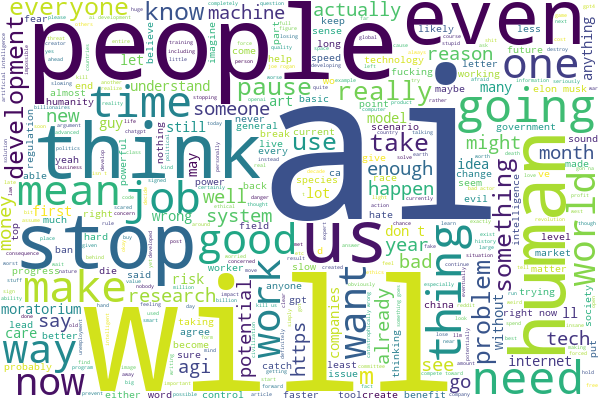

In [370]:
neg_data = ','.join(list(neg_df['new_text'].values))

wordcloud = WordCloud(background_color="white", max_words=1000, contour_color='steelblue', width=600, height=400)

wordcloud.generate(neg_data)

wordcloud.to_image()

In [371]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','s','nt'])

def words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def rmstopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

neg_data = neg_df.new_text.values.tolist()
neg_data_words = list(words(neg_data))
neg_data_words = rmstopwords(neg_data_words)

In [372]:
id2word = corpora.Dictionary(neg_data_words)
neg_texts = neg_data_words
corpus = [id2word.doc2bow(text) for text in neg_texts]
num_topics = 5
lda_model_neg = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pprint(lda_model_neg.print_topics())

doc_lda = lda_model_neg[corpus]

[(0,
  '0.032*"ai" + 0.010*"people" + 0.007*"us" + 0.007*"like" + 0.005*"could" + '
  '0.005*"need" + 0.005*"time" + 0.005*"jobs" + 0.004*"think" + 0.004*"bad"'),
 (1,
  '0.034*"ai" + 0.009*"people" + 0.007*"even" + 0.006*"us" + 0.006*"would" + '
  '0.005*"development" + 0.005*"like" + 0.004*"think" + 0.004*"could" + '
  '0.004*"one"'),
 (2,
  '0.015*"ai" + 0.010*"people" + 0.009*"like" + 0.005*"stop" + 0.005*"think" + '
  '0.004*"would" + 0.004*"us" + 0.004*"even" + 0.004*"get" + '
  '0.004*"development"'),
 (3,
  '0.015*"ai" + 0.013*"people" + 0.011*"stop" + 0.011*"like" + 0.008*"going" + '
  '0.005*"get" + 0.005*"think" + 0.004*"good" + 0.004*"something" + '
  '0.004*"one"'),
 (4,
  '0.022*"ai" + 0.008*"people" + 0.006*"even" + 0.006*"like" + 0.005*"think" + '
  '0.005*"open" + 0.005*"stop" + 0.005*"us" + 0.005*"would" + 0.004*"going"')]


In [373]:
# create an empty DataFrame
topics_df_2 = pd.DataFrame()

# loop through each topic and extract the top 10 words
for idx, topic in lda_model_neg.print_topics(-1):
    words = topic.split("+")
    words_list = [word.split("*")[1].replace('"', '').strip() for word in words]
    
    # add the topic and top 10 words to the DataFrame
    topics_df_2[f"Topic {idx+1}"] = words_list[:10]

# display the DataFrame
print(topics_df_2.to_string(index=False))

Topic 1     Topic 2     Topic 3   Topic 4 Topic 5
     ai          ai          ai        ai      ai
 people      people      people    people  people
     us        even        like      stop    even
   like          us        stop      like    like
  could       would       think     going   think
   need development       would       get    open
   time        like          us     think    stop
   jobs       think        even      good      us
  think       could         get something   would
    bad         one development       one   going


In [374]:
topics_df_2.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,ai,ai,ai,ai,ai
1,people,people,people,people,people
2,us,even,like,stop,even
3,like,us,stop,like,like
4,could,would,think,going,think
5,need,development,would,get,open
6,time,like,us,think,stop
7,jobs,think,even,good,us
8,think,could,get,something,would
9,bad,one,development,one,going


In [375]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./smm_results/neg_results'+str(num_topics))
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_neg, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './smm_results/neg_results'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.013496 -0.006602       1        1  29.093750
1      0.027477 -0.031185       2        1  23.201369
3     -0.051483 -0.013451       3        1  18.838016
4      0.019829  0.025079       4        1  15.970492
2     -0.009319  0.026159       5        1  12.896372, topic_info=           Term       Freq      Total Category  logprob  loglift
17         stop  68.000000  68.000000  Default  30.0000  30.0000
73         like  99.000000  99.000000  Default  29.0000  29.0000
776        open  27.000000  27.000000  Default  28.0000  28.0000
210    thinking  15.000000  15.000000  Default  27.0000  27.0000
1180   probably  14.000000  14.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
41        going   5.304586  58.625437   Topic5  -5.8166  -0.3544
591   something   4.623854  38.241028   Topic5  -5.9540  -0.0645
855       right   4.333052  31.747751   Topic5  -6.0189   0.0567
234        good   4.592870  45.052996   Topic5  -5.9607  -0.2351
112       could   4.670683  55.989675   Topic5  -5.9439  -0.4356

[427 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
747       1  0.138940  ability
747       2  0.555761  ability
747       3  0.138940  ability
747       4  0.138940  ability
747       5  0.138940  ability
...     ...       ...      ...
888       5  0.189025    wrong
1881      5  0.485567       ya
564       2  0.348541     yann
564       5  0.348541     yann
1567      4  0.694849   yeller

[801 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 5, 3])